Let's load some libraries first

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import matplotlib.pyplot as plt
from primaldual_torch import PrimalDual


setting up


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/davidvandijcke/Dropbox (University of Michigan)/rdd/code/fdd/src/utils.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Energy: 432.548859, Error: 0.001676:   8%|▊         | 75/1000 [00:13<02:40,  5.77it/s]  

KeyboardInterrupt: 

Now, we'll create a function with a jump and then randomly sample the same number of points from the function as there are pixels in the evenly spaced image function.

In [4]:

# Generate some random data points from a discontinuous function
np.random.seed(0)
data = np.random.rand(1000, 2)

# Create the grid
# Define the grid dimensions and resolution
xmin, xmax = 0, 1
ymin, ymax = 0, 1
resolution = 0.01
x, y = np.meshgrid(np.arange(xmin, xmax, resolution), np.arange(ymin, ymax, resolution))
grid = np.dstack((x, y))
grid_f = np.zeros(grid.shape[:2])

def f(x,y):
    temp = np.sqrt((x-1/2)**2 + (y-1/2)**2)
    if temp < 1/4:
        return temp
    else:
        return temp + 1/8

# Compute the function values on the grid
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid_f[i, j] = f(grid[i, j][0], grid[i, j][1])
        
# now sample the function values on the data points
grid_sample = np.zeros((data.shape[0],1))
for i in range(data.shape[0]):
        grid_sample[i] = f(data[i,0], data[i,1])
       

The function values, plotted as an image, look like this:

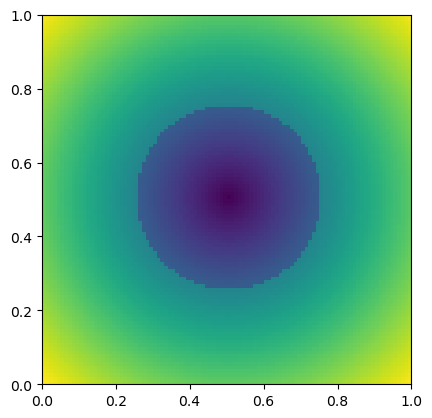

In [3]:
 
# Plot the function values on the grid
plt.imshow(grid_f, extent=(xmin, xmax, ymin, ymax), origin='lower')

As a surface, it looks like this:

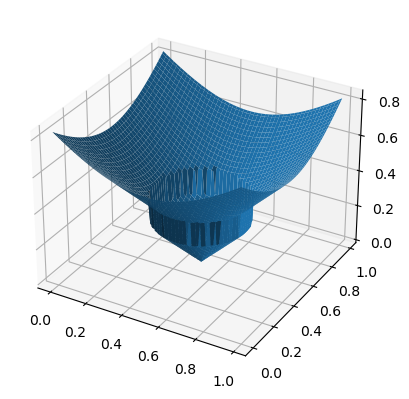

In [4]:
# plot it as a surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, grid_f)
plt.show()


The sampled function values look like this:

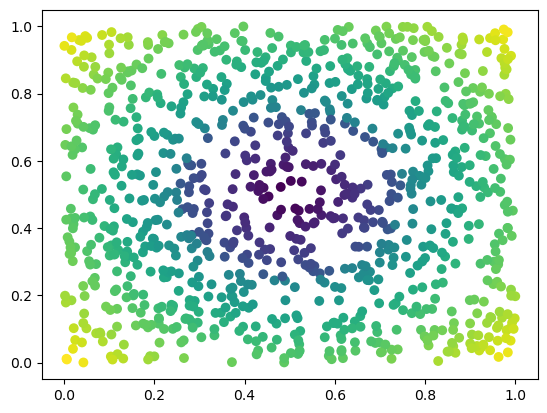

In [5]:
# plot the sampled function values
plt.scatter(data[:, 0], data[:, 1], c=grid_sample,  s=50, edgecolors='none')

Next, we compute the Voronoi diagram for these scattered points and overlay a grid on it.

In [6]:
# Compute the Voronoi diagram for the data points
vor = Voronoi(data)


# Initialize the grid values to NaN
grid_values = np.full(grid.shape[:2], np.nan)

# Iterate over the grid cells
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        # Calculate the distances to the seeds
        distances = np.linalg.norm(vor.points - grid[i, j], axis=1)
        # Find the closest seed
        closest_seed = np.argmin(distances)
        # Assign the value of the corresponding data point to the grid cell
        grid_values[i, j] = grid_sample[closest_seed, :]#.min()


That gives a new image that looks like this:

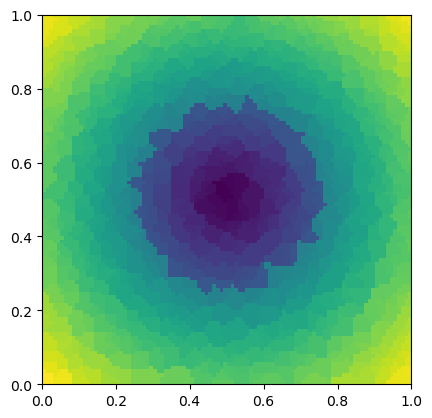

In [7]:
        
plt.imshow(grid_values, extent=(xmin, xmax, ymin, ymax), origin='lower')

Now, we'll segment that image. Write it to a png,

In [8]:
# write to image
import cv2
from skimage import io

grid_rescaled = (255.0 / grid_values.max() * (grid_values - grid_values.min())).astype(np.uint8)

cv2.imwrite('grid_rescaled.png', grid_rescaled)

True

and run the calibration algorithm.

In [17]:
test = PrimalDual(i = "grid_rescaled.png", o = "grid_result.png", parm = "parameters.png", repeats = 1000, gray = True, level = 16, lmbda = 1, nu = 0.01)
test.run()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/davidvandijcke/Dropbox (University of Michigan)/rdd/code/iPAUR-master/src/CUDA/lagrange/utils.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Energy: 8.433811, Error: 0.000053:  46%|████▌     | 461/1000 [01:21<01:35,  5.65it/s]   


The result:

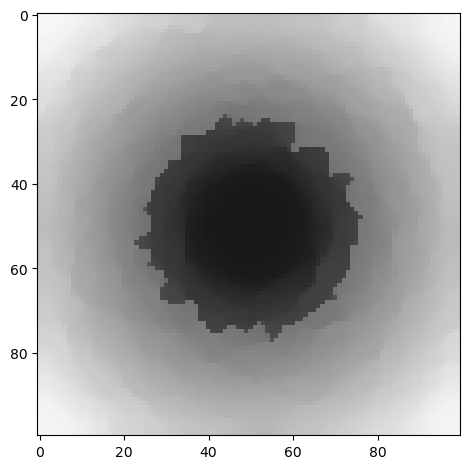

In [9]:
result = cv2.imread('grid_result.png', cv2.IMREAD_GRAYSCALE)

io.imshow(result)

Compare this to the rescaled "true" function:

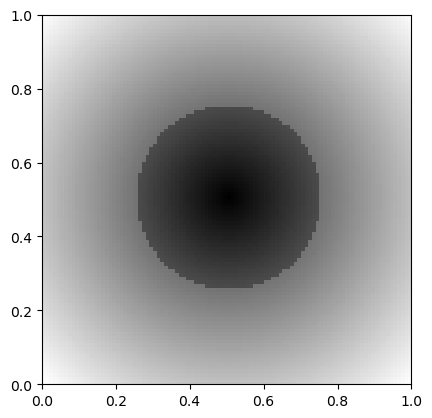

In [10]:
grid_f_rescaled = (255.0 / grid_f.max() * (grid_f - grid_f.min())).astype(np.uint8)
plt.imshow(grid_f, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap = 'gray')

In [12]:
result

array([[247, 247, 246, ..., 245, 245, 245],
       [247, 247, 246, ..., 245, 245, 245],
       [246, 246, 246, ..., 245, 245, 245],
       ...,
       [245, 245, 245, ..., 244, 244, 244],
       [245, 245, 245, ..., 244, 244, 244],
       [245, 245, 245, ..., 244, 244, 244]], dtype=uint8)

Not too shabby!

### Kernel tests

Let's test the kernel approach now. We'll take a kernel with a window size equal to the 0.5th percentile of distance between points -- taking the smallest distance leads to a grid that is way too fine. This means we lose a few data points but only about 0.5%.

In [10]:
import torch 

def setDevice():
    if torch.cuda.is_available(): # cuda gpus
        device = torch.device("cuda")
        #torch.cuda.set_device(int(gpu_id))
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    elif torch.backends.mps.is_available(): # mac gpus
        device = torch.device("mps")
    elif torch.backends.mkl.is_available(): # intel cpus
        device = torch.device("mkl")
    torch.set_grad_enabled(True)
    return device

device = setDevice()


In [31]:

n = data.shape[0]
distances_np = np.sqrt(np.sum(data[:,None,:] - data, axis = 2)**2)
temp = torch.tensor(np.transpose(data), device = device, dtype = torch.float32)
distances = torch.cdist(temp, temp)
min_distance = distances[distances > 0]
min_distance
qile = np.quantile(distances.numpy(force = True), 0.005)
qile

# pythagoras
width = qile * 2 / np.sqrt(2) 
width

NotImplementedError: The operator 'aten::_cdist_forward' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [33]:
temp.shape

torch.Size([2, 1000])

In [28]:
data

array([[0.5488135 , 0.71518937],
       [0.60276338, 0.54488318],
       [0.4236548 , 0.64589411],
       ...,
       [0.41443887, 0.79128155],
       [0.72119811, 0.48010781],
       [0.64386404, 0.50177313]])

We'll set up the grid and assign function values,

In [12]:
xmin, xmax = 0, 1
ymin, ymax = 0, 1
resolution = width
x, y = np.meshgrid(np.arange(xmin, xmax, resolution), np.arange(ymin, ymax, resolution))
grid_kernel = np.dstack((x, y))

grid_f_kernel = np.zeros(grid_kernel.shape[:2])

# find closest data point for each point on grid and assign value
# Iterate over the grid cells
for i in range(grid_kernel.shape[0]):
    for j in range(grid_kernel.shape[1]):
        # Calculate the distances to the seeds
        distances = np.linalg.norm(data - grid_kernel[i,j], axis=1)
        # Find the closest seed
        closest_seed = np.argmin(distances)
        # Assign the value of the corresponding data point to the grid cell
        grid_f_kernel[i, j] = grid_sample[closest_seed, :]#.min()

That gives an image that looks like this:

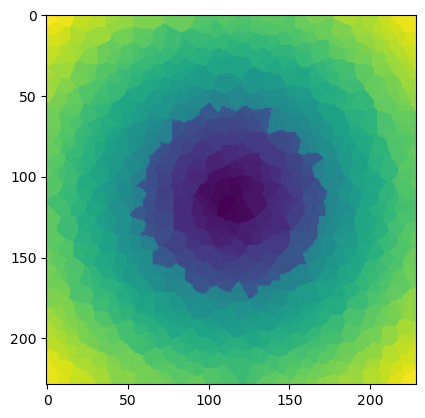

In [13]:
plt.imshow(grid_f_kernel)

Running the calibration algorithm gives the following result:

In [ ]:
# write to image
import cv2
from skimage import io

grid_rescaled = (255.0 / grid_values.max() * (grid_values - grid_values.min())).astype(np.uint8)

cv2.imwrite('grid_kernel.png', grid_rescaled)

test = PrimalDual(i = "grid_kernel.png", o = "grid_kernel_result.png", parm = "parameters.png", repeats = 1000, gray = True, level = 16, lmbda = 1, nu = 0.01)
test.run()


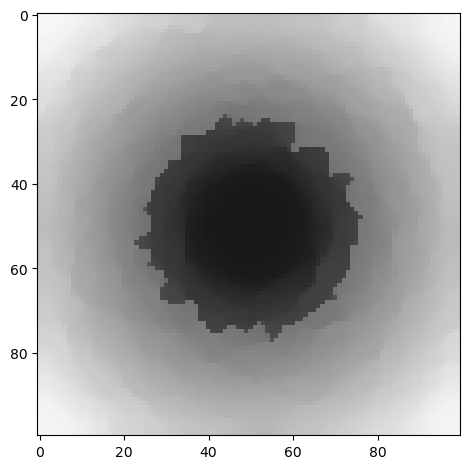

In [15]:
result = cv2.imread('grid_kernel_result.png', cv2.IMREAD_GRAYSCALE)

io.imshow(result)

Compared to the original function.

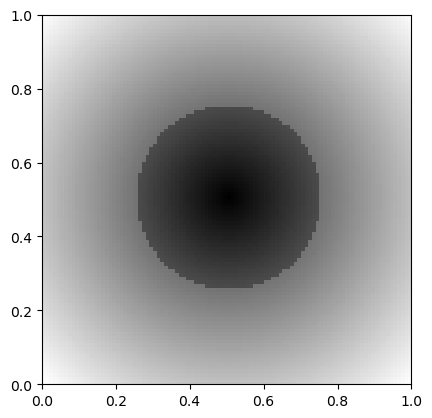

In [16]:
grid_f_rescaled = (255.0 / grid_f.max() * (grid_f - grid_f.min())).astype(np.uint8)
plt.imshow(grid_f, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap = 'gray')

Comparing only the data points, we get: